In [1]:
import pandas as pd
import ast
import seaborn as sns
import re
import numpy as np
import matplotlib.pyplot as plt
import spacy
from itertools import chain
from collections import Counter
import scipy.stats as st
import plotly.express as px
import plotly.colors as pc
import plotly.colors as pc
from sqlalchemy import create_engine

import warnings
warnings.filterwarnings('ignore')

pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", 50)


In [2]:
# functions

def nation(textlist):
    """
    get information about recipe nationality
    """
    text = " ".join(textlist)
    processed = nlp(text)
    nationalities = list(set(i.text for i in processed.ents if i.label_ == "NORP"))
    return nationalities


def serving_size(original):
    """
    this leaves serving_size as int which is in grams
    """
    new = original[1:]
    match = re.findall(r"\d+", new)
    if match:
        return int(match[0])
    return None

<h1 style="color: #FFAA55;">Data</h1>
Create df merging Recipes_1 and Recipes_2  

### Recipes_1
with nutrition values  

### Recipes_2
for using recipes, with servings and ingredient quantity  

### Recipes_3
for nutrition values

<h1 style="color: #FFAA55;">Cleaning</h1>


In [3]:
# import both datasets
df1 = pd.read_csv("./data/recipes_3.csv")
df2 = pd.read_csv("./data/recipes_2.csv")

In [4]:
# create merged df
df1.rename(columns={"RecipeId": "id"}, inplace=True)
df1.drop(columns=["AuthorId", "AuthorName"], inplace=True)
df = pd.merge(df2, df1, on="id", how="left")


In [5]:
# clean df
df.drop(columns=["name", "Description", "ReviewCount", "RecipeYield", "RecipeIngredientParts", "RecipeInstructions", "RecipeServings"], inplace=True)
df.columns = [columns.lower().replace(" ", "_") for columns in df.columns]

In [6]:
# create serving size in grams
df["serving_size"] = df["serving_size"].apply(serving_size)

In [7]:
# unpack tags column
df["new_tags"] = df["tags"].apply(lambda x: ast.literal_eval(x))

In [8]:
# cleaning integer columns (time)

def times(x):
    if pd.notnull(x):
        y = x.replace("PT", "")
        return y
    return None

df["cooktime"] = df["cooktime"].apply(times)
df["preptime"] = df["preptime"].apply(times)
df["totaltime"] = df["totaltime"].apply(times)

<h1 style="color: #FFAA55;">Feature Engineering</h1>

In [9]:
# takes some time
"""
# get information about the nationality of the recipe
nlp = spacy.load("en_core_web_sm")
df["nations"] = df["new_tags"].apply(nation)
"""

df = pd.read_csv("data/master.csv", index_col=False)

In [10]:
ast.literal_eval(df["nations"][2])

def convert_list(x):
    return ast.literal_eval(x)

df["nations"] = df["nations"].apply(convert_list)


In [11]:
#df.to_csv("data/master.csv", index=False)

<h1 style="color: #FFAA55;">Statistics</h1>

In [12]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,494963.0,268932.473191,154558.312287,38.0,135085.5,267958.0,402274.5,537804.0
serving_size,494963.0,375.065344,2702.043601,0.0,122.0,219.0,381.0,1595816.0
servings,494963.0,7.063164,94.677417,1.0,4.0,4.0,8.0,32767.0
aggregatedrating,258307.0,4.629574,0.643114,1.0,4.5,5.0,5.0,5.0
calories,494949.0,487.296062,1417.104646,0.0,179.0,321.2,530.9,612854.6
fatcontent,494949.0,24.839080,113.142935,0.0,5.9,14.0,27.6,64368.1
saturatedfatcontent,494949.0,9.673535,46.877944,0.0,1.6,4.8,10.9,26740.6
cholesterolcontent,494949.0,88.349779,308.180545,0.0,5.5,45.5,110.0,130456.4
sodiumcontent,494949.0,740.142478,3535.812569,0.0,131.3,360.8,796.3,731056.4
carbohydratecontent,494949.0,49.123498,183.721345,0.0,13.1,28.6,51.3,108294.6


In [13]:
df = pd.read_csv("data/master.csv", index_col=False)

asian = df[(df["nations"].str.contains("asian")) & (df["calories"]<3000) & (df["tags"].str.contains("main-dish"))]
american = df[(df["nations"].str.contains("american")) & (df["calories"]<3000)& (df["tags"].str.contains("main-dish"))]

In [14]:
print("average calories count for asian main dishes: ", asian["calories"].mean().round())
print("average calories count for american main dishes: ", american["calories"].mean().round())

average calories count for asian main dishes:  487.0
average calories count for american main dishes:  510.0


Text(0, 0.5, 'Frequency')

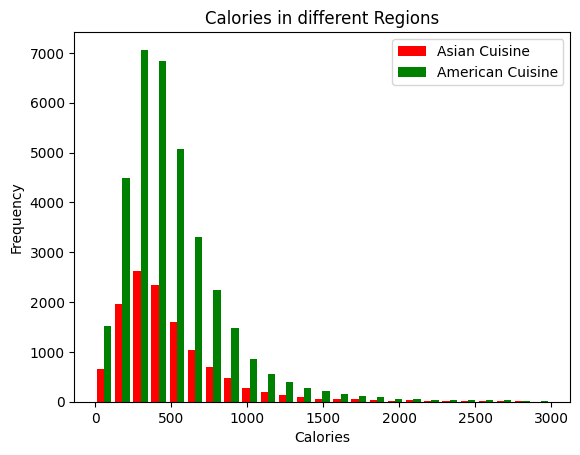

In [15]:
plt.hist([asian["calories"], american["calories"]], color=['r','g'], alpha=1, bins=25)
plt.legend(['Asian Cuisine', 'American Cuisine'])
plt.title("Calories in different Regions")
plt.xlabel("Calories")
plt.ylabel("Frequency")


In [16]:
t_stat, p_value = st.ttest_ind(asian["calories"], american["calories"], alternative = "two-sided")

In [17]:
p_value

9.866656262417696e-11

<h1 style="color: #FFAA55;">Plots</h1>

In [18]:
df_plots = df.dropna(subset=["cooktime", "preptime", "totaltime", "datepublished", "recipeingredientquantities", "calories"])

Text(0, 0.5, 'Number of Recipes')

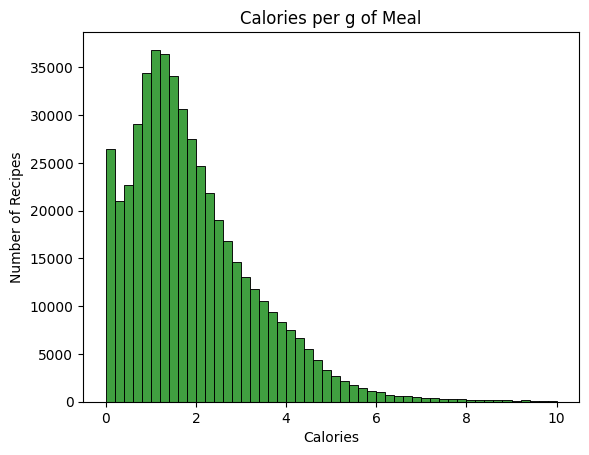

In [19]:
# plot calories per g
df["calories_per_g"] = df["calories"] / df["serving_size"]
cal_plot = df[df["calories_per_g"] < 10]
sns.histplot(cal_plot["calories_per_g"], bins=50, color="Green")

plt.title("Calories per g of Meal")
plt.xlabel("Calories")
plt.ylabel("Number of Recipes")

Text(0, 0.5, 'Number of Recipes')

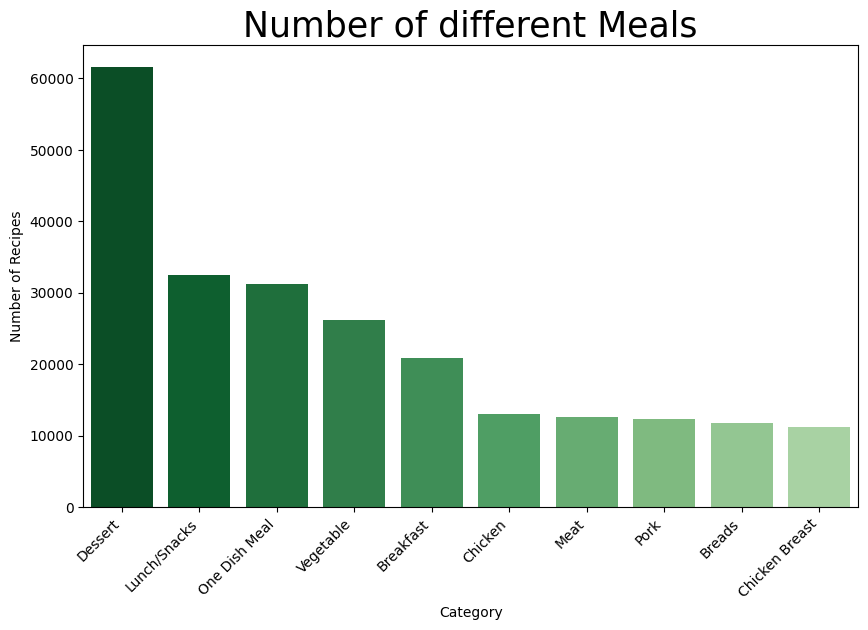

In [20]:
# numbers of different recipes
types = df["recipecategory"].value_counts().head(10)
plt.figure(figsize=(10, 6))
sns.barplot(types, palette=sns.color_palette("Greens_r", 15))
plt.title("Number of different Meals", fontsize=25)
plt.xticks(rotation=45, ha="right")
plt.xlabel("Category")
plt.ylabel("Number of Recipes")

Text(0, 0.5, 'Number of Recipes')

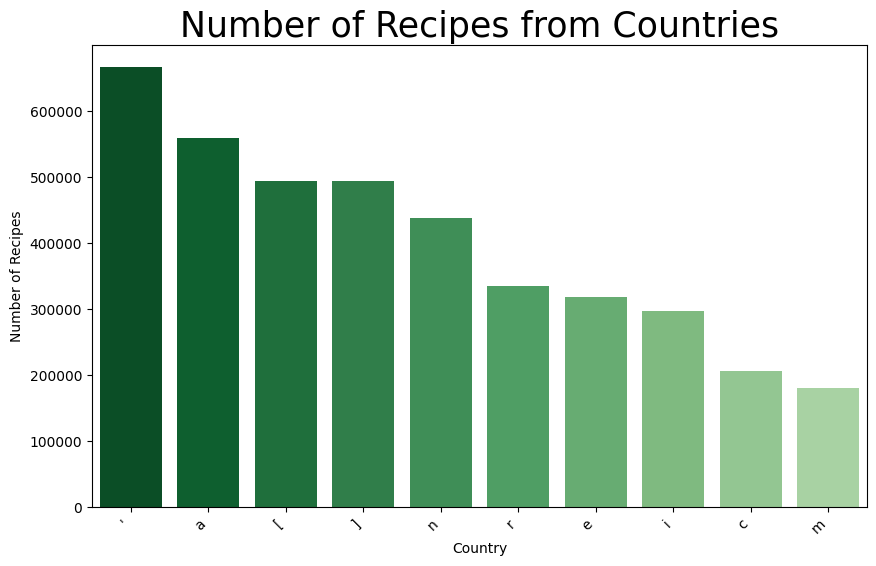

In [23]:
# plot nation information
nations_flat = list(chain.from_iterable(df["nations"]))
counts = pd.Series(nations_flat).value_counts().head(10)

plt.figure(figsize=(10, 6))
sns.barplot(counts, palette=sns.color_palette("Greens_r", 15))

plt.title("Number of Recipes from Countries", fontsize=25)
plt.xticks(rotation=45, ha="right")
plt.xlabel("Country")
plt.ylabel("Number of Recipes")

In [24]:
def tukeys_test_outliers(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    
    # Define bounds for the outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Identify the outliers
    outliers = data[(data < lower_bound) | (data > upper_bound)]
    
    return outliers

<h1 style="color: #FFAA55;">nutritional values analysis</h1>

In [25]:
df.head(5)

,id,description,ingredients,ingredients_raw_str,serving_size,servings,steps,tags,search_terms,name,cooktime,preptime,totaltime,datepublished,images,recipecategory,keywords,recipeingredientquantities,aggregatedrating,calories,fatcontent,saturatedfatcontent,cholesterolcontent,sodiumcontent,carbohydratecontent,fibercontent,sugarcontent,proteincontent,new_tags,nations,calories_per_g
0,96313,"We love grits, this is another good way to ser...","['water', 'grits', 'salt', 'cheddar cheese', '...","[""4 cups water"",""1 cup uncooked old f...",155,8,"['I a sauce pan, bring water to a boil; slowly...","['time-to-make', 'course', 'main-ingredient', ...","{'diabetic', 'low-calorie', 'vegetarian', 'low...",Grilled Garlic Cheese Grits,50M,15M,1H5M,2004-07-24T20:00:00Z,"""https://img.sndimg.com/food/image/upload/w_55...",Grains,"c(""Cheese"", ""Low Cholesterol"", ""Brunch"", ""Refr...","c(""4"", ""1"", ""1"", ""4"", ""1 -2"", ""1"")",5.0,144.8,6.7,3.3,14.9,382.7,15.7,0.9,0.2,5.0,"['time-to-make', 'course', 'main-ingredient', ...",[],0.934194
1,232037,"Simple, easy and very tasty for when you are i...","['onion', 'red bell pepper', 'garlic cloves', ...","[""1 medium onion, chopped coarse "",""1 m...",366,4,"['In a food processor, pulse the onion, red pe...","['60-minutes-or-less', 'time-to-make', 'course...","{'dinner', 'shrimp'}",Simple Shrimp and Andouille Jambalaya,25M,20M,45M,2007-06-03T22:51:00Z,character(0),One Dish Meal,"c(""Pork"", ""Meat"", ""< 60 Mins"", ""Easy"")","c(""1"", ""1"", ""5"", ""1"", NA, NA, ""1"", ""3/4"", ""1 1...",5.0,756.5,28.9,9.0,191.8,2094.9,82.3,3.9,9.7,39.2,"['60-minutes-or-less', 'time-to-make', 'course...",[],2.066940
2,41090,NaN,"['white beans', 'canned black beans', 'tomatoe...","[""1 cup canned white beans, rinsed and dra...",807,1,"['In a large bowl, combine beans, tomato, onio...","['15-minutes-or-less', 'time-to-make', 'course...","{'vegetarian', 'salad', 'side', 'dinner', 'veg...",black-and-white bean salad,NaN,5M,5M,2002-09-24T22:53:00Z,character(0),Black Beans,"c(""Beans"", ""Vegan"", ""Potluck"", ""Spring"", ""Summ...","c(""1"", ""1"", ""1"", ""1"", ""1"", ""1"", ""2"", ""1/8"", ""1...",4.5,159.0,1.6,0.3,0.0,318.3,28.3,8.3,2.1,9.1,"['15-minutes-or-less', 'time-to-make', 'course...","['american', 'north-american']",0.197026
3,60656,This is a good recipe for weight watchers. It ...,"['zucchini', 'yellow squash', 'diced tomatoes'...","[""2 zucchini, sliced "",""2 small yel...",244,4,['Put all ingredients in the crock pot and coo...,"['weeknight', 'time-to-make', 'course', 'main-...","{'side', 'vegetarian', 'italian'}",Crock Pot Italian Zucchini,6H,10M,6H10M,2003-04-22T20:07:00Z,character(0),Vegetable,"c(""Winter"", ""Weeknight"", ""Beginner Cook"", ""Easy"")","c(""2"", ""2"", ""2 -3"", ""1"", ""4"", ""1"", ""2"", ""1"", NA)",4.0,47.1,0.4,0.1,0.0,19.1,10.4,2.7,4.6,2.6,"['weeknight', 'time-to-make', 'course', 'main-...",[],0.193033
4,232047,This is a fabulous stew that came from one of ...,"['beef stew meat', 'flour', 'salt', 'allspice'...","[""3 lbs beef stew meat"",""3 tablespoons ...",358,8,"['Preheat oven to 350°F.', ""Cut beef into 1 in...","['time-to-make', 'course', 'main-ingredient', ...",{'dinner'},Beef Stew With Dried Cherries,2H,45M,2H45M,2007-06-03T23:06:00Z,character(0),Stew,"c(""Meat"", ""< 4 Hours"", ""Easy"")","c(""3"", ""3"", ""1"", ""1/2"", ""1/2"", ""1/2"", ""1"", ""3""...",NaN,691.1,45.8,17.7,177.1,503.6,14.4,1.6,6.8,48.2,"['time-to-make', 'course', 'main-ingredient', ...",[],1.930447


In [26]:
df["recipecategory"].value_counts().head(20)

recipecategory
Dessert           61573
Lunch/Snacks      32448
One Dish Meal     31280
Vegetable         26224
Breakfast         20897
Chicken           13072
Meat              12560
Pork              12282
Breads            11766
Chicken Breast    11201
Potato            10461
Sauces            10427
Beverages         10290
Quick Breads       9968
< 60 Mins          8503
Cheese             8188
< 30 Mins          7853
Pie                7743
Bar Cookie         7016
Drop Cookies       6374
Name: count, dtype: int64

<h1 style="color: #FFAA55;">functionality for app</h1>

In [28]:
melted = df.melt(value_vars=["calories", "fatcontent", "carbohydratecontent", "proteincontent"], var_name="nutrition_values", value_name="value")
melted

,nutrition_values,value
0,calories,144.8
1,calories,756.5
2,calories,159.0
3,calories,47.1
4,calories,691.1
...,...,...
1979847,proteincontent,5.1
1979848,proteincontent,43.2
1979849,proteincontent,46.9
1979850,proteincontent,25.6


<h1 style="color: #FFAA55;">SQL</h1>

In [30]:
# import df to sql, use only rows without nans
"""
sql_df = df[["id", "name", "ingredients", "tags", "cooktime", "preptime", "totaltime", "recipecategory", "keywords", "aggregatedrating", "calories", "fatcontent", "cholesterolcontent", "carbohydratecontent", "sodiumcontent", "sugarcontent", "proteincontent", "nations"]]
sql_df = sql_df[sql_df["nations"] != '[]']
sql_df.dropna(inplace=True)

db_user = "root"
db_password = "12345678"
db_host = "localhost"
db_name = "final_project"

engine = create_engine(f"mysql+pymysql://{db_user}:{db_password}@{db_host}/{db_name}")

sql_df.to_sql("sql_df", con=engine, if_exists="replace", index=False)
"""

'\nsql_df = df[["id", "name", "ingredients", "tags", "cooktime", "preptime", "totaltime", "recipecategory", "keywords", "aggregatedrating", "calories", "fatcontent", "cholesterolcontent", "carbohydratecontent", "sodiumcontent", "sugarcontent", "proteincontent", "nations"]]\nsql_df = sql_df[sql_df["nations"] != \'[]\']\nsql_df.dropna(inplace=True)\n\ndb_user = "root"\ndb_password = "12345678"\ndb_host = "localhost"\ndb_name = "final_project"\n\nengine = create_engine(f"mysql+pymysql://{db_user}:{db_password}@{db_host}/{db_name}")\n\nsql_df.to_sql("sql_df", con=engine, if_exists="replace", index=False)\n'